In [126]:
import pickle, os 
import numpy as np
import pandas as pd
from pathlib import Path
from astropy.table import Table 

data_dir = Path(os.getcwd()).parent / "assets" 
catalog  = data_dir / "jwst_init_NRCB.fits" 

FILTERS = [ 
    ("F115W", "F212N", "NRCB4", "NRCB4", (4, 10), (26, 19), (1.4453, 0.0139, 12.27)), 
    ("F115W", "F323N", "NRCB4", "NRCB5", (5, 11), (26, 19), (1.2460, 0.0485, 12.4)), 
    ("F115W", "F405N", "NRCB4", "NRCB5", (5, 13), (26, 19), (1.1233, 0.0090, 12.45)),
]

catalog = Table.read(catalog)

In [127]:
def get_all_filts(t):
    """
    Helper function to get filts in a catalog, regardless of
    masking

    """
    nepochs = len(t['filt'][0])

    # Loop through each time entry and get year
    # from a non-masked source
    filt_arr = []
    for ii in range(nepochs):
        good = np.where(t['x'][:,ii].mask == False)[0]
        if len(good) > 0:
            filt_arr.append(t['filt'][good[0],ii])
        else:
            filt_arr.append(np.nan)
       
    filt_arr = np.array(filt_arr)
    return filt_arr

def get_all_dets(t): 
    """
    Helper function to get detectors in a catalog, regardless of
    masking

    """
    nepochs = len(t['det'][0])

    # Loop through each time entry and get year
    # from a non-masked source
    det_arr = []
    for ii in range(nepochs):
        good = np.where(t['x'][:,ii].mask == False)[0]
        if len(good) > 0:
            det_arr.append(t['det'][good[0],ii])
        else:
            det_arr.append(np.nan)

    det_arr = np.array(det_arr)
   
    return det_arr

def get_matches(t, filt1, det1, filt2, det2): 
    filt = get_all_filts(t)
    det = get_all_dets(t)

    idx1 = np.where( (filt == filt1) & (det == det1) ) 
    idx2 = np.where( (filt == filt2) & (det == det2) ) 

    filt_1 = t['m'][:,idx1]
    filt_2 = t['m'][:,idx2]
    filt_1me = t['me'][:,idx1]
    filt_2me = t['me'][:,idx2]
    
    good = np.where( (filt_1.mask == False) & (filt_2.mask == False) )
    m_filt1_match  = filt_1[good]
    m_filt2_match  = filt_2[good]
    me_filt1_match = filt_1me[good]
    me_filt2_match = filt_2me[good]

    return m_filt1_match, m_filt2_match, me_filt1_match, me_filt2_match

def get_csv_matches(csv_loc, filt1, region1, filt2, region2):
    
    df = pd.read_csv(csv_loc)

    region_map = {
        'NRCB1': '',
        'NRCB2': '.1',
        'NRCB3': '.2',
        'NRCB4': '.3'
    }

    suffix1 = region_map.get(region1, '')
    suffix2 = region_map.get(region2, '')

    column1 = f"{filt1}{suffix1}"  
    column2 = f"{filt2}{suffix2}"      

    array1 = df[column1]
    array2 = df[column2]

    combined_df = pd.DataFrame({column1: array1, column2: array2})
    
    filtered_df = combined_df.dropna()

    return filtered_df[column1], filtered_df[column2]

def validate_filter_region(filter_name, region):
    if filter_name in ["F323N", "F405N"]:
        assert region == "NRCB5", f"\n[ERROR] Filter {filter_name} demands region NRCB5"
    if filter_name in ["F115W", "F212N"]: 
        assert region in ["NRCB1", "NRCB2", "NRCB3", "NRCB4"], f"\n[ERROR] Filter {filter_name} must be NRCB1,2,3,4"


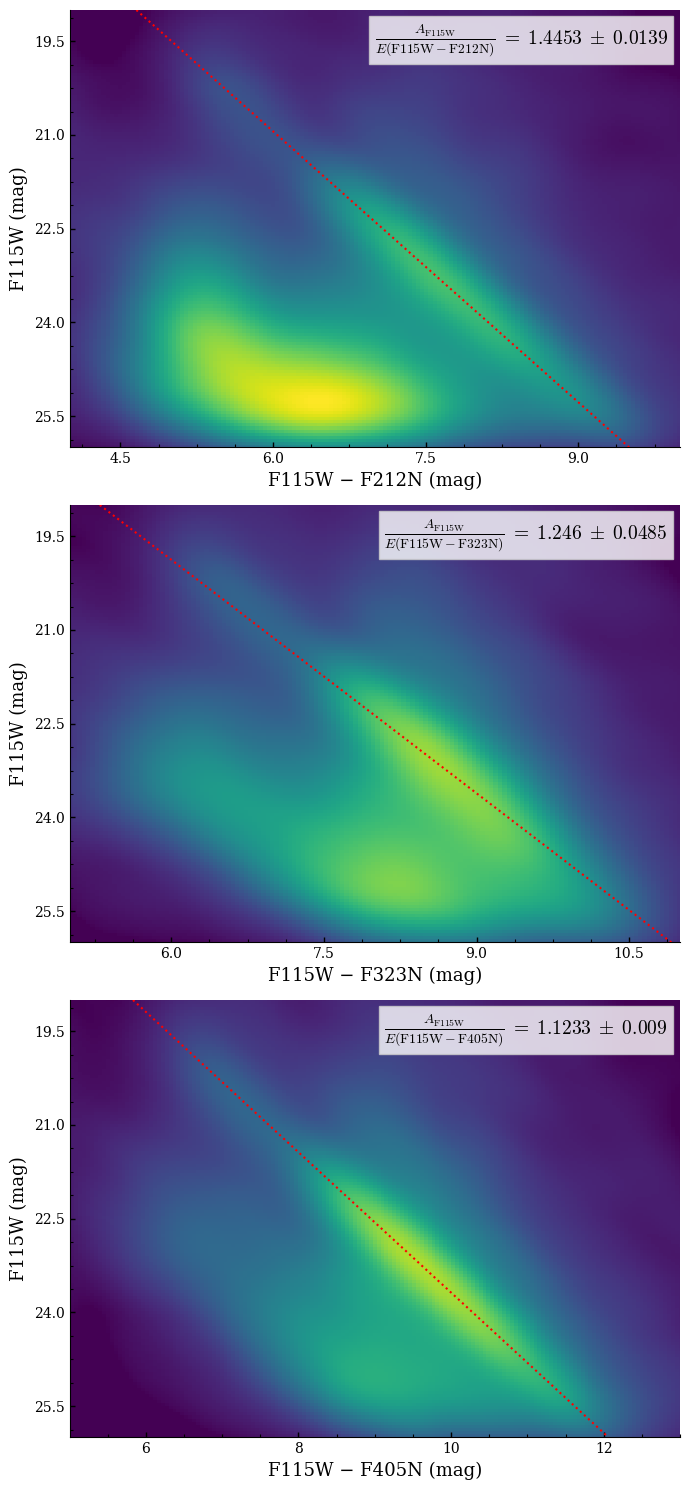

In [129]:
from scipy.stats import gaussian_kde
from matplotlib.colors import PowerNorm
from matplotlib.ticker import MaxNLocator, AutoMinorLocator

plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.width": 1.0,
    "ytick.major.width": 1.0,
    "xtick.minor.width": 0.8,
    "ytick.minor.width": 0.8,
})

nbins = 300
grids = []  
zmax = 0.0

for (filt1, filt2, reg1, reg2, (xmin, xmax), (ymax, ymin), (slope, err, intercept)) in FILTERS:
    m1, m2, m1e, m2e = get_matches(catalog, filt1, reg1, filt2, reg2)
    x = np.subtract(m1, m2)
    y = np.asarray(m1)

    k = gaussian_kde([x, y])
    xi, yi = np.mgrid[
        x.min():x.max():nbins*1j,
        y.min():y.max():nbins*1j
    ]
    zi = k(np.vstack([xi.ravel(), yi.ravel()])).reshape(xi.shape)

    zmax = max(zmax, float(np.nanmax(zi)))
    grids.append({
        "filt1": filt1, "filt2": filt2,
        "xmin": xmin, "xmax": xmax, "ymin": ymin, "ymax": ymax,
        "slope": slope, "err": err, "intercept": intercept,
        "xi": xi, "yi": yi, "zi": zi
    })

norm = PowerNorm(gamma=0.5, vmin=zmax * 1e-3, vmax=zmax)

fig, ax = plt.subplots(len(grids), 1, figsize=(7, 15), constrained_layout=True)
if len(grids) == 1:
    ax = [ax]

mappables = []
for idx, g in enumerate(grids):
    pcm = ax[idx].pcolormesh(
        g["xi"], g["yi"], g["zi"],
        cmap="viridis", norm=norm, shading="auto",
        rasterized=True
    )
    mappables.append(pcm)

    ax[idx].axline(
        xy1=(0, g["intercept"]), slope=g["slope"],
        color="red", linestyle=":", linewidth=1.5, zorder=5
    )

    ax[idx].set_xlim(g["xmin"], g["xmax"])
    ax[idx].set_ylim(g["ymax"], g["ymin"])

    ax[idx].xaxis.set_major_locator(MaxNLocator(5))
    ax[idx].yaxis.set_major_locator(MaxNLocator(5))
    ax[idx].xaxis.set_minor_locator(AutoMinorLocator())
    ax[idx].yaxis.set_minor_locator(AutoMinorLocator())

    filt1, filt2 = g["filt1"], g["filt2"]
    ax[idx].set_xlabel(f"{filt1} − {filt2} (mag)", fontsize=13)
    ax[idx].set_ylabel("F115W (mag)", fontsize=13)

    text = (
        rf"$\frac{{A_{{\mathrm{{{filt1}}}}}}}{{E(\mathrm{{{filt1}}}-\mathrm{{{filt2}}})}}"
        rf"\;=\;{g['slope']:.5g}\;\pm\;{g['err']:.5g}$"
    )
    ax[idx].text(
        0.98, 0.89, text, transform=ax[idx].transAxes,
        ha="right", va="bottom", fontsize=14,
        bbox=dict(fc="white", ec="0.8", alpha=0.8)
    )


plt.tight_layout()
plt.savefig("/Users/vinland/mulab/paper/NRCB4_CMDs.png", dpi=500)
plt.show()